## **PROJECT: CREDIT SCORING**

## **Phần 1: Dữ liệu, ràng buộc và mô hình hóa khả năng hành động**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

### **1.	Mô tả bộ dữ liệu**

In [ ]:
df = pd.read_csv("german_credit_data.csv")

In [ ]:
df.head()

Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own             NaN           little   
1           1   22  female    2     own          little         moderate   
2           2   49    male    1     own          little              NaN   
3           3   45    male    2    free          little           little   
4           4   53    male    2    free          little           little   

   Credit amount  Duration              Purpose  Risk  
0           1169         6             radio/TV  good  
1           5951        48             radio/TV   bad  
2           2096        12            education  good  
3           7882        42  furniture/equipment  good  
4           4870        24                  car   bad

In [ ]:
df = df.drop(columns=[col for col in df.columns if 'Unnamed' in col])
df.head()

Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own             NaN           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little              NaN           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose  Risk  
0         6             radio/TV  good  
1        48             radio/TV   bad  
2        12            education  good  
3        42  furniture/equipment  good  
4        24                  car   bad

<details>
<summary><strong> Note: </strong></summary>

Cột Unnamed: 0 thường được tạo ra khi bạn lưu file CSV mà không tắt index=True => Không cần thiết
</details>

### **2. EDA**

In [ ]:
# Phân loại biến
categorical_features = ['Sex','Housing', 'Saving accounts', 'Checking account', 'Purpose']
numerical_features = ['Age', 'Job', 'Credit amount', 'Duration']

In [ ]:
# Biến không thể thay đổi
immutable = ['Sex', 'Age']
# Biến nhạy cảm
sensitive = ['Sex']
# Biến dễ thay đổi
soft_to_change = ['Duration', 'Saving accounts', 'Checking account']
# Biến khó thay đổi
hard_to_change = ['Housing','Job', 'Credit amount', 'Purpose']

In [ ]:
sns.set_theme(style="whitegrid")

**Phân phối nhãn mục tiêu**

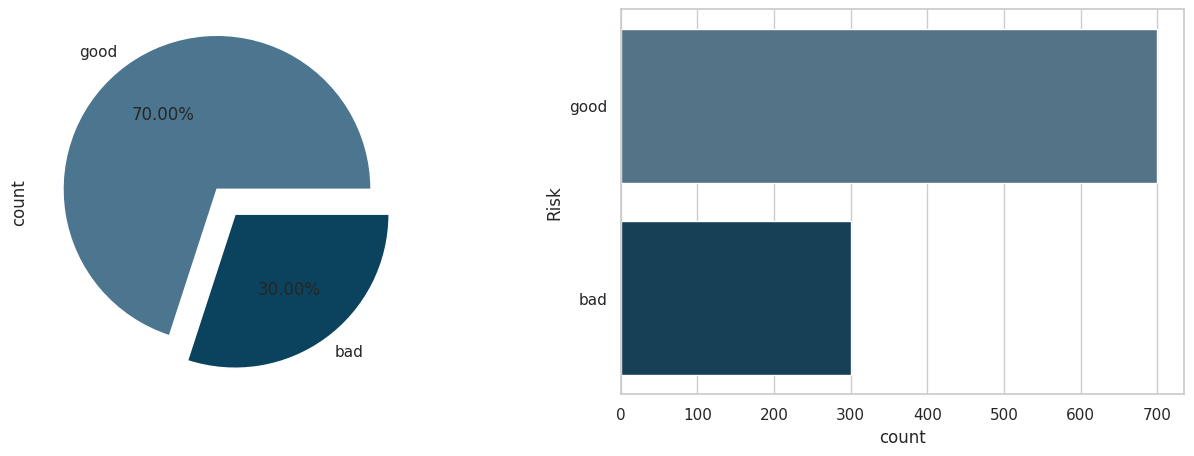

In [ ]:
# Tỷ lệ biến mục tiêu
df['Risk'].value_counts()
df['Risk'].value_counts(normalize=True)

# Biểu đồ thể hiện biến mục tiêu
fig,ax=plt.subplots(ncols=2,figsize=(16,5))
df["Risk"].value_counts().plot.pie(autopct="%.2f%%",colors=["#4C758F","#0B435F"],explode = (0.1, 0.1),ax=ax[0])
sns.countplot(df["Risk"],ax=ax[1],palette=["#4C758F","#0B435F"]);

<details>
<summary><strong> Insight: </strong></summary>

* Biểu đồ thể hiện phần trăm phân phối của 2 lớp Good và Bad. Mặc dù có sự mất cân bằng giữa 2 lớp 30-70, nhưng không ảnh hưởng nhiều đến quá trình đưa ra dự đoán của các mô hình. Vì vậy, không cần thiết hải cân bằng giá trị cột Risk.

</details>

**EDA - Immutable (Protected group)**

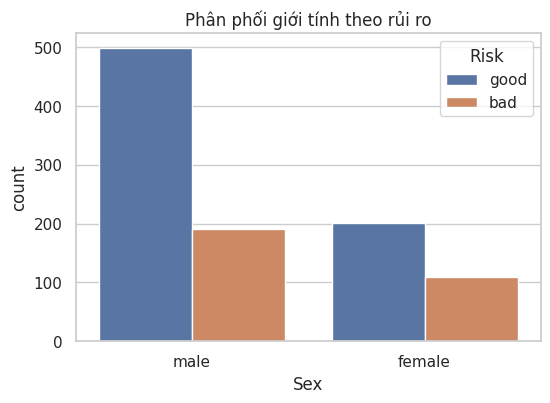

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Sex', hue='Risk', data=df)
plt.title('Phân phối giới tính theo rủi ro');

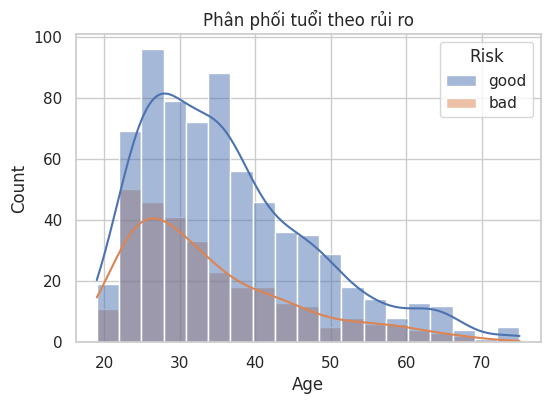

In [ ]:
plt.figure(figsize=(6, 4))
sns.histplot(data=df, x='Age', kde=True, hue='Risk')
plt.title('Phân phối tuổi theo rủi ro');

**EDA- Soft to change**

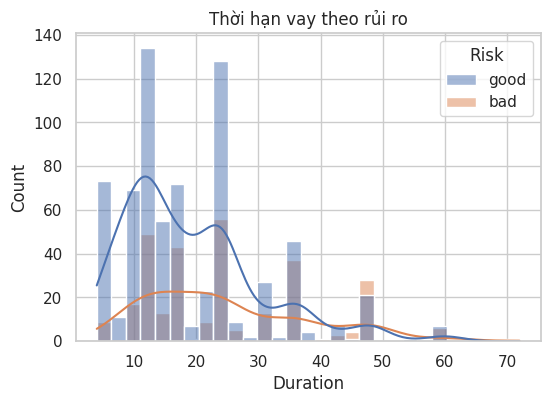

In [ ]:
plt.figure(figsize=(6, 4))
sns.histplot(df, x='Duration', kde=True, hue='Risk')
plt.title('Thời hạn vay theo rủi ro');

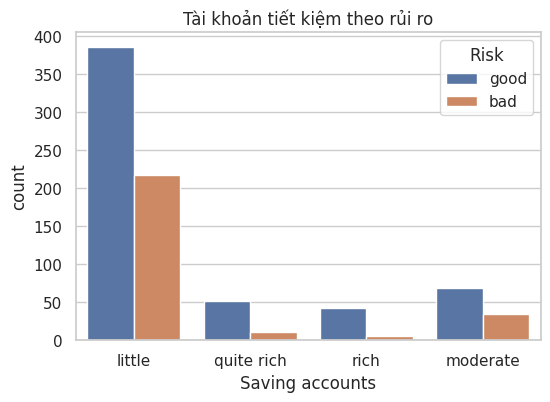

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Saving accounts', hue='Risk', data=df)
plt.title('Tài khoản tiết kiệm theo rủi ro');

**EDA- Hard to change**

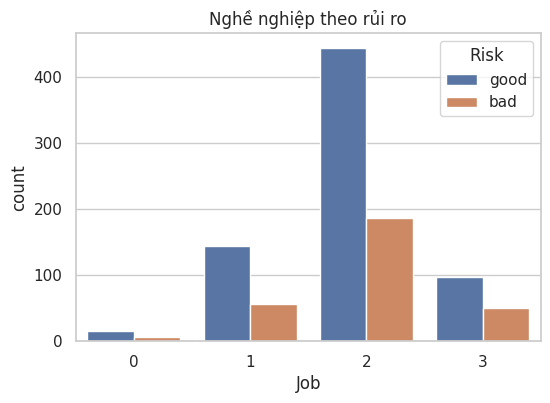

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Job', hue='Risk', data=df)
plt.title('Nghề nghiệp theo rủi ro');

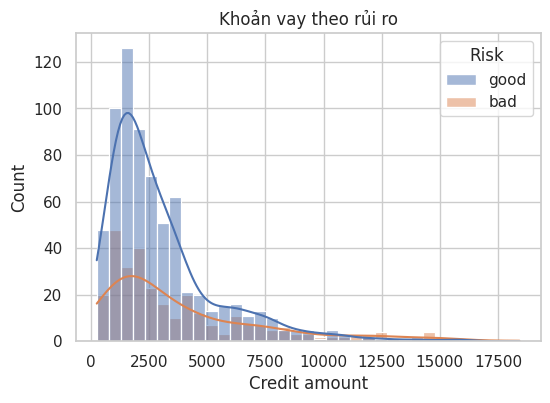

In [ ]:
plt.figure(figsize=(6, 4))
sns.histplot(df, x='Credit amount', kde=True, hue='Risk')
plt.title('Khoản vay theo rủi ro');

**Ước lượng burden**

In [ ]:
# Tạo chỉ số
df['burden'] = df['Credit amount'] / df['Duration']

In [ ]:
cat_vars = [ 'Age', 'Job', 'Saving accounts', 'Purpose']
# Chia tuổi thành 3 nhóm: Trẻ, Trung niên, Lớn tuổi
df['Age_group'] = pd.cut(df['Age'], bins=[18, 30, 50, 100], labels=['Trẻ', 'Trung niên', 'Lớn tuổi'])

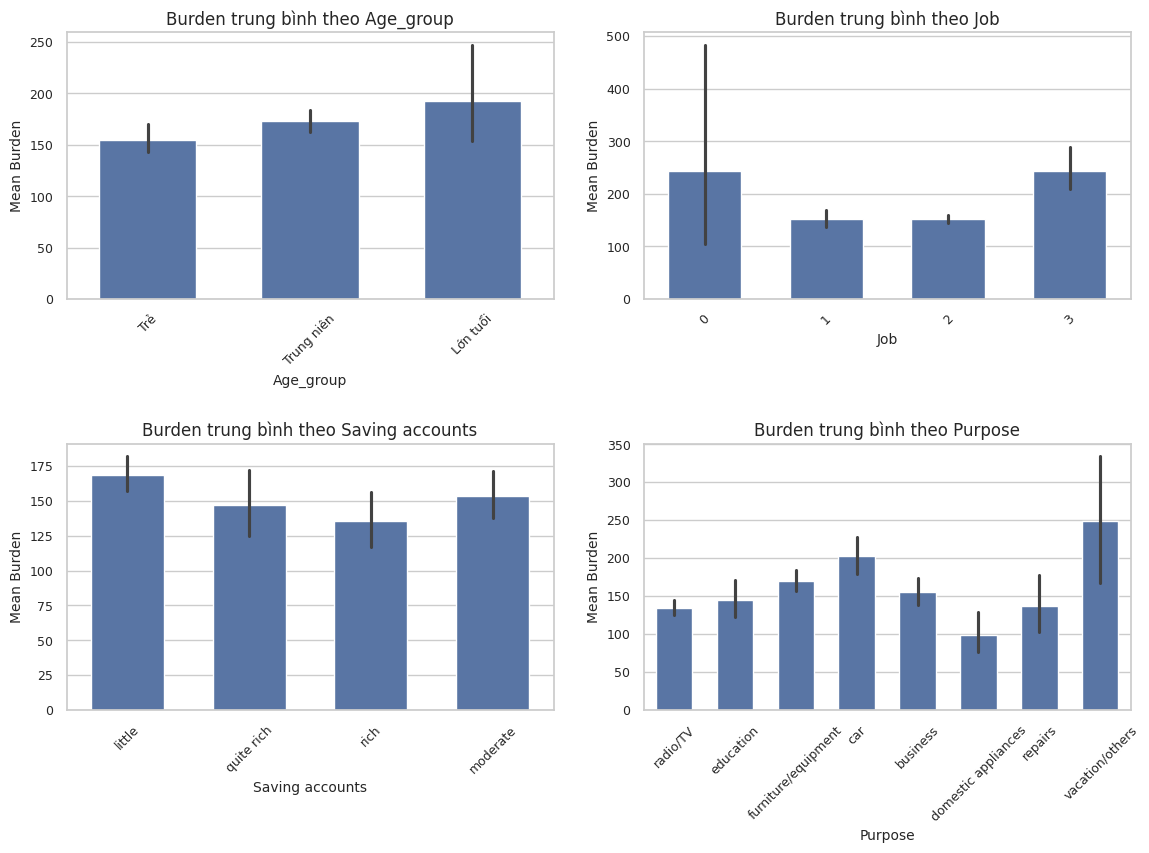

In [ ]:
sns.set_theme(style="whitegrid")

cat_vars = ['Age_group', 'Job', 'Saving accounts', 'Purpose']
n_cols = 2
n_rows = int(np.ceil(len(cat_vars) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4.5 * n_rows))
axes = axes.flatten()

for i, var in enumerate(cat_vars):
    sns.barplot(
        x=var,
        y='burden',
        data=df,
        estimator=np.mean,
        ci=95,
        ax=axes[i],
        width=0.6             # thu nhỏ cột
    )
    axes[i].set_title(f'Burden trung bình theo {var}', fontsize=12)
    axes[i].set_ylabel('Mean Burden', fontsize=10)
    axes[i].set_xlabel(var, fontsize=10)
    axes[i].tick_params(axis='x', rotation=45, labelsize=9)
    axes[i].tick_params(axis='y', labelsize=9)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=2)
plt.show()

### **3. Tiền xử lý dữ liệu**

**Kiểm tra khung dữ liệu**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Age               1000 non-null   int64   
 1   Sex               1000 non-null   object  
 2   Job               1000 non-null   int64   
 3   Housing           1000 non-null   object  
 4   Saving accounts   817 non-null    object  
 5   Checking account  606 non-null    object  
 6   Credit amount     1000 non-null   int64   
 7   Duration          1000 non-null   int64   
 8   Purpose           1000 non-null   object  
 9   Risk              1000 non-null   object  
 10  burden            1000 non-null   float64 
 11  Age_group         1000 non-null   category
dtypes: category(1), float64(1), int64(4), object(6)
memory usage: 87.2+ KB


**Xử lý dữ liệu thiếu**

In [ ]:
# Saving accounts & Checking account thiếu
df['Saving accounts'] = df['Saving accounts'].fillna(df['Saving accounts'].mode()[0])
df['Checking account'] = df['Checking account'].fillna(df['Checking account'].mode()[0])

**Mã hóa biến cate**

In [ ]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

**Chuẩn hóa dữ liệu**

In [ ]:
from sklearn.preprocessing import StandardScaler

numerical_features = ['Age', 'Job', 'Credit amount', 'Duration']
scaler = StandardScaler()
df_encoded[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])

**Phân chia train-test**

In [ ]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop('Risk_good', axis=1)
y = df_encoded['Risk_good']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

**Xử lý imbalance và đánh giá tác động đến fairness**

In [ ]:
# kiểm tra
y_train.value_counts(normalize=True)

Risk_good
True     0.7
False    0.3
Name: proportion, dtype: float64

### **4.	Định nghĩa ràng buộc và khả năng hành động**

**Xác định immutable/sensitive features và luật cấm thay đổi**

In [ ]:
# Biến không thể thay đổi
immutable = ['Sex', 'Age']
# Biến nhạy cảm
sensitive = ['Sex']
# Biến dễ thay đổi
soft_to_change = ['Duration', 'Saving accounts', 'Checking account']
# Biến khó thay đổi
hard_to_change = ['Housing','Job', 'Credit amount', 'Purpose']

**Luật cấm thay đổi**

Kịch bản 1: STRICT

| `Tham số`    | Giá trị                                         | Ý nghĩa ràng buộc                      |
| ----------- | --------------------------------------------- | ---------------------------- |
| `immutable_cols`  | Age, Job,Sex              | Không được thay đổi              |
| `prevent_unknown_cols` | Saving accounts, Checking account | Không cho phép giá trị unknown xuất hiện |
| ` prevent_increase_cols`  | Credit amount, Duration      | Không được phép tăng (chỉ giảm hoặc giữ nguyên)            |
| ` prevent_change_cols`  | Purpose      | Không được thay đổi (giữ nguyên mục đích vay như ban đầu)            |
| ` age_limit`  |   -    | Không cho phép tăng tuổi            |
| ` custom_rules`  | -      | Không có ràng buộc bổ sung nào khác trong kịch bản này            |

Kịch bản 2 : RELAXED

| `Tham số`    | Giá trị                                         | Ý nghĩa ràng buộc                      |
| ----------- | --------------------------------------------- | ---------------------------- |
| `immutable_cols`  | Age, Job,Sex              | Không được thay đổi              |
| `prevent_unknown_cols` | - | 	Không ràng buộc, có thể chứa giá trị "unknown" |
| ` prevent_increase_cols`  | -      | Không ràng buộc, được phép tăng hoặc giảm            |
| ` prevent_change_cols`  | -      | Không ràng buộc, có thể thay đổi bất kỳ biến nào khác            |
| ` age_limit`  |   None    | Không giới hạn, được phép tăng tuổi nếu cần            |
| ` custom_rules`  | -      | Không có ràng buộc bổ sung nào khác trong kịch bản này            |

Kịch bản 3  : FUTURE 1YR PLAN

| `Tham số`    | Giá trị                                         | Ý nghĩa ràng buộc                      |
| ----------- | --------------------------------------------- | ---------------------------- |
| `immutable_cols`  | Job,Sex              | Không được thay đổi              |
| `prevent_unknown_cols` | Saving accounts | 	Cấm sinh counterfactual chứa giá trị "unknown" trong Saving accounts |
| ` prevent_increase_cols`  | Credit amount, Duration      | Không được phép tăng số tiền vay hoặc thời hạn vay            |
| ` prevent_change_cols`  | Purpose      | Mục đích vay giữ nguyên, không được đổi            |
| ` age_limit`  |   1    | Cho phép tăng tuổi tối đa 1 năm            |
| ` custom_rules`  | Nếu Duration tăng → Credit amount phải giảm ≥10%      | Tăng thời hạn chỉ hợp lý nếu số tiền vay giảm đáng kể (plausibility rule)            |

**Thiết kế plausibility rules - sử dụng cho CFE**



*   Rule 1: Duration không được vượt quá 60 tháng
*   Rule 2: Credit amount không âm
*   Rule 3: Saving accounts không thể từ "none" thành "rich"
*   Rule 4: Nếu Duration tăng thì Credit amount phải giảm ít nhất 10%





**Mô hình chi phí: gán trọng số thay đổi từng feature**

In [ ]:
# Trọng số phản ánh độ khó thay đổi
feature_costs = {
    'Duration': 1.0,          # đổi kỳ hạn: dễ, ngắn hạn
    'Saving accounts': 2.0,   # cần tích lũy
    'Checking accounts': 1.5, # mở/duy trì tài khoản giao dịch: khá dễ
    'Credit amount': 2.5,     # giảm khoản vay: vừa đến khó
    'Job': 3.0,               # đổi nghề/ngạch: khó
    'Housing': 4.0,           # đổi loại nhà ở: rất khó
    'Purpose': 3.5            # đổi mục đích vay: khó & ràng buộc tính hợp lý
}

feature_difficulties = {
    'Duration': 1.0,
    'Saving accounts': 1.5,
    'Checking accounts': 1.2,
    'Credit amount': 2.0,
    'Job': 3.0,
    'Housing': 4.0,
    'Purpose': 3.0
}

**Định nghĩa actionability score: hàm kết hợp proximity, cost, plausibility, thời gian/khó khăn**

**1. Định nghĩa actionability score**
$$
\text{Actionability Score} = \sum (\text{proximity} \times \text{cost} \times \text{difficulty})
\quad \text{(chỉ tính nếu thỏa mãn tất cả plausibility)}
$$



**2. Hàm kết hợp**

In [ ]:
# Hàm tính điểm hành động
def compute_actionability_score(original, cf,
                                cost_dict, diff_dict,
                                plausibility_fn=None, norm=False):
  # cost_dict= trọng số thi phí thay đổi từng biến
  # diff_dict= điểm độ khó thay đổi từng biến
  # plausibility_fn= hàm kiểm tra tính hợp lý
  # khởi tạo biến lưu tổng điểm, tổng thay đổi và số biến đã thay đổi
    score = 0
    total_delta = 0
    n_feats_changed = 0

    for feat in cost_dict:
        if feat not in original or feat not in cf:
            continue

        x = original[feat]
        x_prime = cf[feat]

        if x != x_prime:
            # Nếu là số thì tính delta, nếu là chuỗi thì delta = 1
            try:
                delta = abs(float(x) - float(x_prime))
            except:
                delta = 1  # Với categorical → delta = 1 nếu khác

            cost = cost_dict.get(feat, 1.0)
            difficulty = diff_dict.get(feat, 1.0)

            if plausibility_fn is not None:
                if not plausibility_fn(feat, x, x_prime):
                    return float('inf')  # Vi phạm quy tắc

            score += delta * cost * difficulty
            total_delta += delta
            n_feats_changed += 1

    if norm and n_feats_changed > 0:
        return score / n_feats_changed
    return score

**Chuẩn hóa “burden” như tổng chi phí cần để đổi quyết định**

In [ ]:
# Hàm tính
def compute_burden(original, cf, feature_costs, feature_difficulties):
    burden = 0
    for feat in feature_costs:
        if feat in original and feat in cf and original[feat] != cf[feat]:
            # Kiểm tra loại dữ liệu
            try:
                delta = abs(float(cf[feat]) - float(original[feat])) if isinstance(cf[feat], (int, float)) else 1
            except:
                delta = 1
            burden += delta * feature_costs[feat] * feature_difficulties[feat]
    return burden

# **Phần 2: Khung recourse tích hợp và phương pháp**

**1.	Mô hình chấm điểm tín dụng nền tảng**

**Lựa chọn (Random Forest, XGBoost, logistic regression), huấn luyện, tuning, lưu model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000)
}

In [ ]:
from sklearn.metrics import f1_score

best_model = None
best_score = 0
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, pos_label=True)  # hoặc 1 nếu bạn encode nhãn

    results[name] = f1

    print(f"{name} - F1-score (bad): {f1:.4f}")

    if f1 > best_score:
        best_score = f1
        best_model = model
        best_name = name
print(f"\n Best Model: {best_name} with F1-score = {best_score:.4f}")

import joblib
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(X_train.columns.tolist(), 'model_features.pkl')

Random Forest - F1-score (bad): 0.7961
XGBoost - F1-score (bad): 0.8027
Logistic Regression - F1-score (bad): 0.8013

 Best Model: XGBoost with F1-score = 0.8027


['model_features.pkl']

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score
# Train mô hình XGBoost
model = XGBClassifier(max_depth=3, use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Đánh giá trên train
y_train_pred = model.predict(X_train)
y_train_prob = model.predict_proba(X_train)[:,1]
print("Train - Classification Report")
print(classification_report(y_train, y_train_pred))
print("Train AUC: {:.4f}".format(roc_auc_score(y_train, y_train_prob)))

# Đánh giá trên test
y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)[:,1]
print("\nTest - Classification Report")
print(classification_report(y_test, y_test_pred))
print("Test AUC: {:.4f}".format(roc_auc_score(y_test, y_test_prob)))


Train - Classification Report
              precision    recall  f1-score   support

       False       0.96      0.78      0.86       240
        True       0.91      0.99      0.95       560

    accuracy                           0.92       800
   macro avg       0.94      0.88      0.90       800
weighted avg       0.93      0.92      0.92       800

Train AUC: 0.9768

Test - Classification Report
              precision    recall  f1-score   support

       False       0.46      0.27      0.34        60
        True       0.73      0.86      0.79       140

    accuracy                           0.69       200
   macro avg       0.60      0.57      0.57       200
weighted avg       0.65      0.69      0.66       200

Test AUC: 0.6250


**2.	Surrogate Decision Tree**

**Local Surrogate Tree**

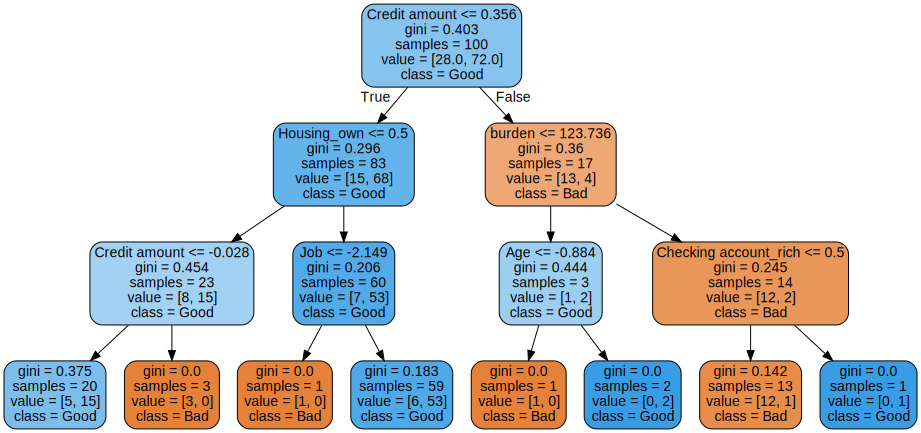

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

x0 = X_test.iloc[[0]]

# Fit mô hình tìm lân cận
nn = NearestNeighbors(n_neighbors=100)
nn.fit(X_train)

# Lấy chỉ số của các điểm gần nhất
_, indices = nn.kneighbors(x0)

# Lấy dữ liệu gần x0
X_local = X_train.iloc[indices[0]]
y_local = best_model.predict(X_local)

# Huấn luyện cây quyết định
local_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
local_tree.fit(X_local, y_local)

# Vẽ cây bằng graphviz
dot_data = export_graphviz(local_tree, out_file=None,
                           feature_names=X_train.columns,
                           class_names=['Bad', 'Good'],
                           filled=True, rounded=True)

graphviz.Source(dot_data)


**Global Surrogate Tree**

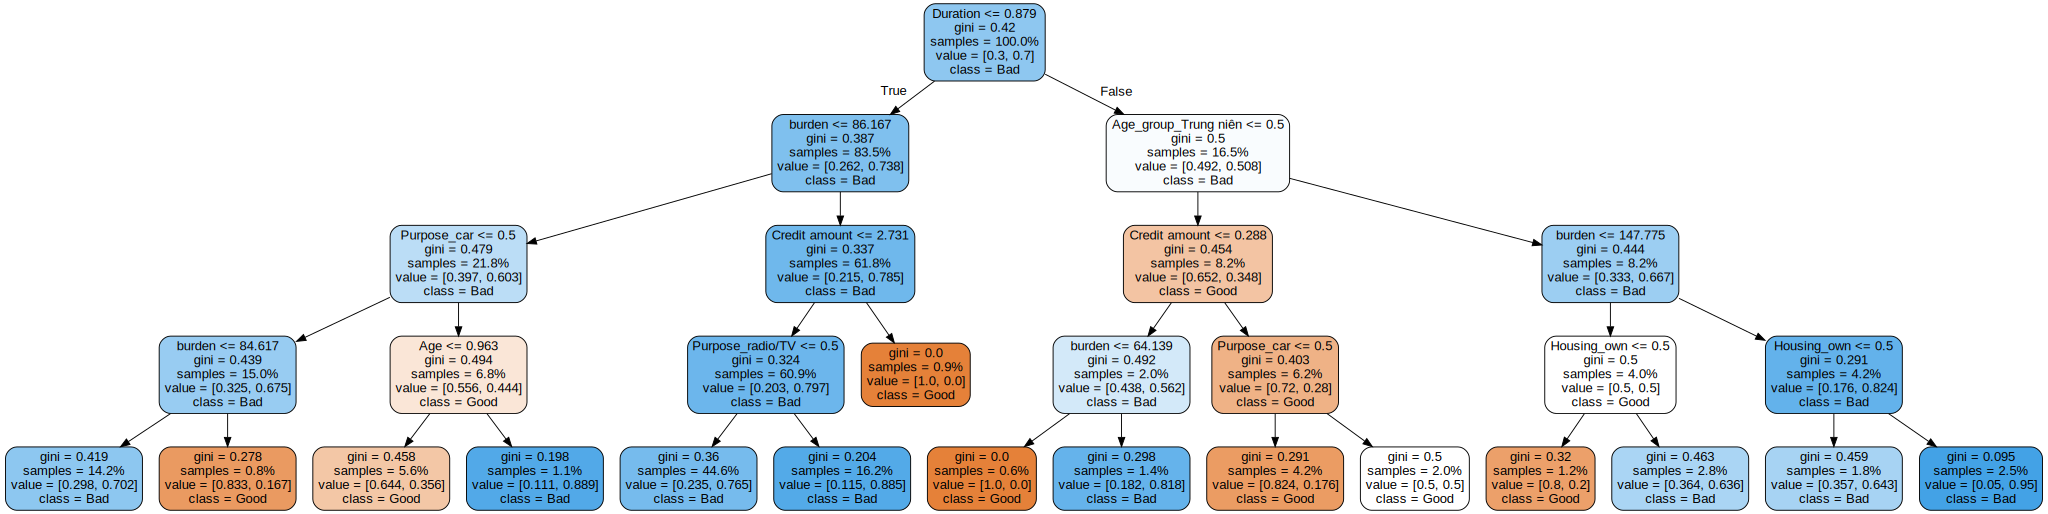

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

# Huấn luyện lại cây Decision Tree surrogate global
model_dt = DecisionTreeClassifier(max_depth=4, random_state=42)
model_dt.fit(X_train, y_train)

# Xuất dữ liệu cây theo định dạng DOT dùng Graphviz
dot_data = export_graphviz(model_dt,
                           out_file=None,
                           feature_names=X_train.columns,
                           class_names=['Good', 'Bad'],
                           filled=True,
                           rounded=True,
                           proportion=True)

# Tạo và hiển thị bằng graphviz
graphviz.Source(dot_data)

**3.	Sinh lời giải thích phản thực tế hành động được với DiCE**

In [ ]:
df = pd.read_csv('german_credit_data.csv')
df.drop(columns=["Unnamed: 0"], inplace=True)
df["Risk"] = df["Risk"].map({"good": 1, "bad": 0})
df.head()

Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own             NaN           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little              NaN           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose  Risk  
0         6             radio/TV     1  
1        48             radio/TV     0  
2        12            education     1  
3        42  furniture/equipment     1  
4        24                  car     0

In [ ]:
# 2. Handle missing categorical by 'unknown'
categorical_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
numerical_cols = ['Age', 'Job', 'Credit amount', 'Duration']
df[categorical_cols] = df[categorical_cols].fillna("unknown")

In [ ]:
# 3. Split data
X = df.drop(columns=["Risk"])
y = df["Risk"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median"))])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, numerical_cols),
    ("cat", cat_pipe, categorical_cols)
])

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age', 'Job',
                                                   'Credit amount',
                                                   'Duration']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Housing',
                                                   'Saving accounts',
                                                   'Checking account',
                                                   'Purpose'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [ ]:
# Đánh giá mô hình
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.47      0.52        60
           1       0.79      0.86      0.82       140

    accuracy                           0.74       200
   macro avg       0.69      0.66      0.67       200
weighted avg       0.73      0.74      0.73       200



In [ ]:
import joblib
joblib.dump(pipeline, "credit_model_pipeline.pkl")

['credit_model_pipeline.pkl']

## CFE

In [ ]:
!pip install dice-ml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 22.8 MB/s eta 0:00:00


In [ ]:
import dice_ml
from dice_ml import Dice
import warnings
warnings.filterwarnings("ignore")

### **Cấu hình DiCE: feature types, immutable/features, cost/actionability setup, desired target**

Tạo wrapper cho DiCE (giúp nhận dữ liệu gốc chưa encode)

In [ ]:
class SklearnPipelineWrapper:
    def __init__(self, pipeline, num_cols, cat_cols):
        self.pipeline = pipeline
        self.num_cols = num_cols
        self.cat_cols = cat_cols
        self.preprocessor = pipeline.named_steps['preprocessor']
        self.classifier = pipeline.named_steps['classifier']

    def predict_proba(self, df):
        X_proc = self.preprocessor.transform(df)
        return self.classifier.predict_proba(X_proc)

Tạo DiCE Explainer

In [ ]:
df_full = pd.concat([X, y], axis=1) # Dùng full dataset cho cfe

data_dice = dice_ml.Data(
    dataframe=df_full,
    continuous_features=numerical_cols,
    categorical_features=categorical_cols,
    outcome_name="Risk"
)

wrapped_model = SklearnPipelineWrapper(pipeline, numerical_cols, categorical_cols)
model_dice = dice_ml.Model(model=wrapped_model, backend="sklearn")
exp = Dice(data_dice, model_dice, method="genetic")

Note: method - phương pháp sinh counterfactual:

| `method`    | Mô tả                                         | Ưu điểm                      |
| ----------- | --------------------------------------------- | ---------------------------- |
| `'random'`  | Chọn ngẫu nhiên, nhanh, đơn giản              | Dễ dùng, nhanh               |
| `'genetic'` | Dựa trên thuật toán di truyền, tối ưu tốt hơn | Đa dạng hơn, kết quả đẹp hơn |
| `'kdtree'`  | Tìm điểm gần nhất trong tập dữ liệu thật      | Gợi ý thực tế hơn            |


### 3.2. Sinh counterfactuals

**Workflow & pseudocode: từ input bị từ chối → generate CF → tính metric → lọc → ranking**

Chọn 1 mẫu bị mô hình từ chối

In [ ]:
# Chọn 1 mẫu mà mô hình dự đoán là bad (0)
#chọn mẫu thứ m trong số mẫu bị reject
m = 1
query_instance = X_test[y_pred == 0].iloc[[m]]

original = query_instance.iloc[0] # lưu lại trạng thái gốc dùng để đối sánh

In [ ]:
query_instance

Age   Sex  Job Housing Saving accounts Checking account  Credit amount  \
998   23  male    2    free          little           little           1845   

     Duration   Purpose  
998        45  radio/TV

Tìm tất cả các phương án CF của mẫu bị từ chối

In [ ]:
cf = exp.generate_counterfactuals(query_instances=query_instance, total_CFs=20, desired_class=1)
cf_df = cf.cf_examples_list[0].final_cfs_df
cf_df.head(10)

100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   23    male    2    free          little         moderate           1534   
0   23    male    2    free          little         moderate           1534   
0   29    male    2    free          little           little           2149   
0   23  female    2     own          little           little           1498   
0   23    male    2    rent          little         moderate           1534   
0   23    male    2     own          little         moderate           1498   
0   24  female    2    free          little           little           1498   
0   19    male    2     own          little           little           2101   
0   26    male    2     own          little           little            250   
0   19    male    2     own          little           little           1534   

   Duration   Purpose  Risk  
0        18  radio/TV     1  
0        12  radio/TV     1  
0        12  radio/TV     1  
0        12  radio/TV     1  
0        12  radio/TV     1  
0        12  radio/TV     1  
0        12  radio/TV     1  
0        13  radio/TV     1  
0        12  radio/TV     1  
0        12  radio/TV     1

**Tính metric: **

In [ ]:
from numpy.linalg import norm
from itertools import combinations

original = query_instance.iloc[0]

def minmax01(s):
    s = s.astype(float)
    den = s.max() - s.min()
    return (s - s.min()) / (den + 1e-9)

# --- Validity ---
validity_preds = pipeline.predict(cf_df[numerical_cols + categorical_cols])
validity = np.mean(validity_preds == 1)

# --- Proximity ---
x0 = scaler.transform(original[numerical_cols].to_frame().T)[0]
xc = scaler.transform(cf_df[numerical_cols])
cf_df["proximity"] = [norm(x0 - x) for x in xc]
cf_df["proximity_norm"] = minmax01(cf_df["proximity"])

# --- Sparsity ---
def compute_sparsity(orig, cf_row, feats):
    return sum(orig[f] != cf_row[f] for f in feats)

all_feats = numerical_cols + categorical_cols
cf_df["sparsity"] = cf_df.apply(lambda row: compute_sparsity(original, row, all_feats), axis=1)
cf_df["sparsity_norm"] = cf_df["sparsity"] / len(all_feats)

# --- Burden ---
delta = np.abs(cf_df[numerical_cols] - original[numerical_cols].values.reshape(1, -1))
burden = np.zeros(len(cf_df))

for j, feat in enumerate(numerical_cols):
    burden += delta.iloc[:, j] * feature_costs.get(feat, 1)

for col in categorical_cols:
    orig_val = original[col]
    changed = (cf_df[col] != orig_val).astype(int)
    burden += changed * feature_costs.get(col, 1)

cf_df["burden"] = burden
cf_df["burden_norm"] = minmax01(cf_df["burden"])

# --- Diversity ---
# Áp dụng cho từng cặp counterfactual
tuples = scaler.transform(cf_df[numerical_cols])
pair_dists = [norm(a - b) for a, b in combinations(tuples, 2)]
diversity = np.mean(pair_dists)

# --- In kết quả ---
print(f"Validity: {validity:.2f}")
print(f"Proximity (mean): {cf_df['proximity_norm'].mean():.4f}")
print(f"Sparsity (mean): {cf_df['sparsity_norm'].mean():.2f}")
print(f"Burden mean: {cf_df['burden_norm'].mean():.4f}")
print(f"Diversity: {diversity:.4f}")

Validity: 1.00
Proximity (mean): 0.5492
Sparsity (mean): 0.44
Burden mean: 0.2370
Diversity: 1.1559


### 3.3. Chọn lọc lại các mẫu hợp lý dựa trên domain-specific

**Thiết lập quy tắc lọc**

In [ ]:
import pandas as pd
from numpy.linalg import norm

def filter_cfes(cf_df: pd.DataFrame, original: pd.Series, config: dict) -> pd.DataFrame:
    """
    Lọc Counterfactuals theo cấu hình 'config'.

    Args:
      cf_df     : DataFrame chứa các CF từ DiCE
      original  : Series mẫu gốc
      config    : dict cấu hình các rule, có thể gồm:
        - immutable_cols       : list tên cột giữ nguyên hoàn toàn
        - prevent_unknown_cols : list tên cột cấm chuyển sang 'unknown'
        - prevent_increase_cols: list tên cột cấm tăng giá trị số
        - prevent_change_cols  : list tên cột giữ nguyên
        - age_limit            : int (max tăng tuổi), nếu None bỏ qua
        - custom_rules         : list các hàm fn(row, original)->bool

    Returns:
      DataFrame các CF thỏa tất cả rule
    """
    # 1. Khởi tạo mask True
    mask = pd.Series(True, index=cf_df.index)

    # 2. immutable_cols
    for c in config.get("immutable_cols", []):
        if c in cf_df:
            mask &= cf_df[c] == original[c]

    # 3. prevent_unknown_cols
    for c in config.get("prevent_unknown_cols", []):
        if c in cf_df and original[c] != "unknown":
            mask &= cf_df[c] != "unknown"

    # 4. prevent_increase_cols
    for c in config.get("prevent_increase_cols", []):
        if c in cf_df:
            mask &= cf_df[c] <= original[c]

    # 5. prevent_change_cols
    for c in config.get("prevent_change_cols", []):
        if c in cf_df:
            mask &= cf_df[c] == original[c]

    # 6. age_limit
    max_inc = config.get("age_limit", None)
    if max_inc is not None and "Age" in cf_df:
        a0 = original["Age"]
        mask &= (cf_df["Age"] >= a0) & (cf_df["Age"] <= a0 + max_inc)

    # 7. custom_rules
    for fn in config.get("custom_rules", []):
        mask &= cf_df.apply(lambda row: fn(row, original), axis=1)

    return cf_df[mask].copy()

**Lọc các CFE theo quy tắc xác định**

Kịch bản 1:

In [ ]:
# Kịch bản STRICT (Age immutable, cấm tăng, cấm unknown, giữ Purpose)

strict_cfg = {
    "immutable_cols":       ["Sex", "Job", "Age"],
    "prevent_unknown_cols": ["Saving accounts", "Checking account"],
    "prevent_increase_cols":["Credit amount", "Duration"],
    "prevent_change_cols":  ["Purpose"],
    "age_limit":            0,
    "custom_rules":         []
}

filtered_strict = filter_cfes(cf_df, original, strict_cfg)
# Tính proximity trên các cột số
num_cols = [c for c in ["Credit amount","Duration"] if c in filtered_strict]
filtered_strict["proximity"] = filtered_strict[num_cols].apply(
    lambda r: norm(r.values - original[num_cols].values), axis=1
)
top3_strict = filtered_strict.nsmallest(3, "proximity").reset_index(drop=True)

print(f"STRICT: CFs trước={len(cf_df)}, sau lọc={len(filtered_strict)}")
display(top3_strict)


STRICT: CFs trước=20, sau lọc=4


Age   Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   23  male    2    free          little         moderate           1534   
1   23  male    2    free          little         moderate           1534   
2   23  male    2    rent          little         moderate           1534   

   Duration   Purpose  Risk   proximity  proximity_norm  sparsity  \
0        18  radio/TV     1  312.169826        0.410590         3   
1        12  radio/TV     1  312.745903        0.549297         3   
2        12  radio/TV     1  312.745903        0.549297         4   

   sparsity_norm burden  burden_norm  
0       0.333333  805.5     0.148520  
1       0.333333  811.5     0.150106  
2       0.444444  815.5     0.151163

Kịch bản 2:

In [ ]:
# Kịch bản RELAXED (chỉ khóa sensitive fields)

relaxed_cfg = {
    "immutable_cols":       ["Sex", "Job", "Age"],
    "prevent_unknown_cols": [],
    "prevent_increase_cols":[],
    "prevent_change_cols":  [],
    "age_limit":            None,
    "custom_rules":         []
}

filtered_relaxed = filter_cfes(cf_df, original, relaxed_cfg)
num_cols = [c for c in ["Credit amount","Duration"] if c in filtered_relaxed]
filtered_relaxed["proximity"] = filtered_relaxed[num_cols].apply(
    lambda r: norm(r.values - original[num_cols].values), axis=1
)
top3_relaxed = filtered_relaxed.nsmallest(3, "proximity").reset_index(drop=True)

print(f"RELAXED: CFs trước={len(cf_df)}, sau lọc={len(filtered_relaxed)}")
display(top3_relaxed)

RELAXED: CFs trước=20, sau lọc=4


Age   Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   23  male    2    free          little         moderate           1534   
1   23  male    2    free          little         moderate           1534   
2   23  male    2    rent          little         moderate           1534   

   Duration   Purpose  Risk   proximity  proximity_norm  sparsity  \
0        18  radio/TV     1  312.169826        0.410590         3   
1        12  radio/TV     1  312.745903        0.549297         3   
2        12  radio/TV     1  312.745903        0.549297         4   

   sparsity_norm burden  burden_norm  
0       0.333333  805.5     0.148520  
1       0.333333  811.5     0.150106  
2       0.444444  815.5     0.151163

Kịch bản 3:

In [ ]:
# Cell 4: Kịch bản FUTURE 1YR PLAN (tuổi+1, cấm tăng nhưng thêm custom rule)

future_cfg = {
    "immutable_cols":       ["Sex", "Job"],
    "prevent_unknown_cols": ["Saving accounts"],
    "prevent_increase_cols":["Credit amount", "Duration"],
    "prevent_change_cols":  ["Purpose"],
    "age_limit":            1,
    "custom_rules": [
        # Nếu Duration tăng, phải giảm ít nhất 10% Credit amount
        lambda r, o: not (
            (r["Duration"] > o["Duration"]) and
            (r["Credit amount"] >= 0.9 * o["Credit amount"])
        )
    ]
}

filtered_future = filter_cfes(cf_df, original, future_cfg)
num_cols = [c for c in ["Credit amount","Duration"] if c in filtered_future]
filtered_future["proximity"] = filtered_future[num_cols].apply(
    lambda r: norm(r.values - original[num_cols].values), axis=1
)
top3_future = filtered_future.nsmallest(3, "proximity").reset_index(drop=True)

print(f"FUTURE 1YR: CFs trước={len(cf_df)}, sau lọc={len(filtered_future)}")
display(top3_future)


FUTURE 1YR: CFs trước=20, sau lọc=4


Age   Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   23  male    2    free          little         moderate           1534   
1   23  male    2    free          little         moderate           1534   
2   23  male    2    rent          little         moderate           1534   

   Duration   Purpose  Risk   proximity  proximity_norm  sparsity  \
0        18  radio/TV     1  312.169826        0.410590         3   
1        12  radio/TV     1  312.745903        0.549297         3   
2        12  radio/TV     1  312.745903        0.549297         4   

   sparsity_norm burden  burden_norm  
0       0.333333  805.5     0.148520  
1       0.333333  811.5     0.150106  
2       0.444444  815.5     0.151163

**DIỄN GIẢI KẾT QUẢ CHO END-USER**

In [ ]:
def propose_changes(original: pd.Series, cf_df: pd.DataFrame) -> list[str]:
    """
    Sinh gợi ý thay đổi từ mẫu gốc sang các phương án top-k counterfactuals.

    Args:
        original: Series là mẫu gốc (ví dụ query_instance.iloc[0])
        cf_df    : DataFrame các CFEs (ví dụ top_k), giữ nguyên cùng index 0...k-1

    Returns:
        suggestions: list chuỗi mô tả các thay đổi cho mỗi phương án
    """
    suggestions = []

    # Duyệt qua từng CF
    for i, row in cf_df.iterrows():
        diffs = []
        # So sánh từng cột
        for col in original.index:
            if col in cf_df.columns and not pd.isna(original[col]) and original[col] != row[col]:
                diffs.append((col, original[col], row[col]))
        # Nếu có sự khác biệt, sinh câu đề xuất
        if diffs:
            parts = [f"{col} từ {orig} → {new}" for col, orig, new in diffs]
            suggestion = f"Phương án {i+1}: " + "; ".join(parts)
            suggestions.append(suggestion)

    return suggestions


**Ranking**

In [ ]:
# Giả sử original, top_k đã có sẵn
original = query_instance.iloc[0]

# top_k là DataFrame 3 CFs gần nhất
top_k = top3_strict #chọn kịch bản restrict

suggestions = propose_changes(original, top_k)

for s in suggestions:
    print(s)

Phương án 1: Checking account từ little → moderate; Credit amount từ 1845 → 1534; Duration từ 45 → 18
Phương án 2: Checking account từ little → moderate; Credit amount từ 1845 → 1534; Duration từ 45 → 12
Phương án 3: Housing từ free → rent; Checking account từ little → moderate; Credit amount từ 1845 → 1534; Duration từ 45 → 12


**Đánh giá CF của query_instance**

Metrics: Validity, Proximity, Sparsity, Diversity, Feasibility

**Chuẩn hóa lại data**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X_train[numerical_cols].astype(float))

In [ ]:
# Dự đoán lại các CF
validity_preds = pipeline.predict(cf_df[X.columns])
validity = np.mean(validity_preds == 1)
print(f"Validity: {validity:.2f}")

Validity: 1.00


In [ ]:
from numpy.linalg import norm

# scale dữ liệu numerical trước
X_scaled = scaler.transform(query_instance[numerical_cols])
cf_scaled = scaler.transform(cf_df[numerical_cols])

cf_df["proximity"] = [
    norm(cf_scaled[i] - X_scaled[0])
    for i in range(len(cf_df))
]

avg_proximity = cf_df["proximity"].mean()
print(f"Proximity (scaled Euclidean): {avg_proximity:.4f}")

# chuẩn hoá về [0,1]
cf_df["proximity_norm"] = (
    (cf_df["proximity"] - cf_df["proximity"].min()) /
    (cf_df["proximity"].max() - cf_df["proximity"].min() + 1e-9)
)
print(f"Proximity (normalized): {cf_df['proximity_norm'].mean():.4f}")

Proximity (scaled Euclidean): 0.4900
Proximity (normalized): 0.5012


In [ ]:
def compute_sparsity(original, cf):
    return sum(original[feat] != cf[feat] for feat in original.index if feat in cf)

# original là 1 Series (query_instance.iloc[0])
cf_df["sparsity"] = cf_df.apply(lambda row: compute_sparsity(original, row), axis=1)

avg_sparsity = cf_df["sparsity"].mean()
print(f"Sparsity (avg #changed features): {avg_sparsity:.2f}")

# Chuẩn hoá về [0,1]
cf_df["sparsity_norm"] = (
    (cf_df["sparsity"] - cf_df["sparsity"].min()) /
    (cf_df["sparsity"].max() - cf_df["sparsity"].min() + 1e-9)
)
print(f"Sparsity (normalized): {cf_df['sparsity_norm'].mean():.4f}")

Sparsity (avg #changed features): 4.00
Sparsity (normalized): 0.5000


In [ ]:
from itertools import combinations

def euclidean_dist(x1, x2):
    return np.linalg.norm(x1 - x2)

cf_numeric = cf_df[numerical_cols].to_numpy()

if len(cf_numeric) >= 2:
    pairwise_dists = [euclidean_dist(x1, x2) for x1, x2 in combinations(cf_numeric, 2)]
    diversity = np.mean(pairwise_dists)
else:
    diversity = 0

print(f"Diversity (numeric space): {diversity:.4f}")

#norm
if len(cf_numeric) >= 2:
    min_d, max_d = min(pairwise_dists), max(pairwise_dists)
    diversity_norm = (diversity - min_d) / (max_d - min_d + 1e-9)
else:
    diversity_norm = 0

print(f"Diversity (normalized): {diversity_norm:.4f}")

Diversity (numeric space): 567.4395
Diversity (normalized): 0.2737


In [ ]:
immutable = ["Sex", "Job"]
feasible_cf = cf_df.copy()
for col in immutable:
    feasible_cf = feasible_cf[feasible_cf[col] == query_instance.iloc[0][col]]

feasibility = len(feasible_cf) / len(cf_df)
print(f"Feasibility (preserve immutable): {feasibility:.2f}")

Feasibility (preserve immutable): 0.80


In [ ]:
plausibility_rules = [
    # Rule 1: Duration không được vượt quá 60 tháng
    lambda r, o: r["Duration"] <= 60,
    # Rule 2: Credit amount không âm
    lambda r, o: r["Credit amount"] >= 0,
    # Rule 3: Saving accounts không thể từ "none" thành "rich"
    lambda r, o: not (o["Saving accounts"] == "none" and r["Saving accounts"] == "rich"),
    # Rule 4: Nếu Duration tăng thì Credit amount phải giảm ít nhất 10%
    lambda r, o: not (r["Duration"] > o["Duration"] and r["Credit amount"] >= 0.9 * o["Credit amount"])
]
def check_plausibility(row, original, rules):
    for rule in rules:
        if not rule(row, original):
            return False
    return True

cf_df["plausibility"] = cf_df.apply(lambda row: check_plausibility(row, original, plausibility_rules), axis=1)
print(cf_df["plausibility"].value_counts())

n_valid = cf_df["plausibility"].sum()   # vì True=1, False=0
n_total = len(cf_df)

print(f"Số CF hợp lệ: {n_valid}/{n_total}")

plausibility
True    20
Name: count, dtype: int64
Số CF hợp lệ: 20/20


In [ ]:
all_feats = numerical_cols + categorical_cols

**Fix lỗi original cols**

In [ ]:
print(type(original))

<class 'pandas.core.series.Series'>


In [ ]:
print("Các feature trong original (dạng Series):", list(original.index))

Các feature trong original (dạng Series): ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose']


In [ ]:
# Lọc các cột gốc của cf_df (loại bỏ các cột tính toán như burden, risk,...)
base_features = ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose']

# Chuẩn hóa index của original
original = original.copy()
original.index = original.index.str.strip().str.title()

# Chỉ giữ lại feature tồn tại trong cf_df
valid_features = [feat for feat in original.index if feat in base_features]
original = original.loc[valid_features]

# In kiểm tra
print("original index sau chuẩn hóa:", list(original.index))
print("base_features:", base_features)
print("cf_df.columns:", list(cf_df.columns))


original index sau chuẩn hóa: ['Age', 'Sex', 'Job', 'Housing', 'Duration', 'Purpose']
base_features: ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose']
cf_df.columns: ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk', 'proximity', 'proximity_norm', 'sparsity', 'sparsity_norm', 'burden', 'burden_norm', 'plausibility']


In [ ]:
def compute_burden(orig_row, cf_row, feature_costs, feature_difficulties):
    burden = 0.0
    for feat in feature_costs.keys():
        if feat not in orig_row or feat not in cf_row:
            continue
        try:
            delta = abs(float(orig_row[feat]) - float(cf_row[feat]))
        except:
            delta = 1 if orig_row[feat] != cf_row[feat] else 0
        burden += delta * feature_costs[feat] * feature_difficulties[feat]
    return burden


In [ ]:
# 1. Tạo bản gốc gán cho orig_row_dict
orig_row_dict = original.to_dict()  # original là Series duy nhất

# 2. Tính burden từng dòng của cf_df
cf_df["burden"] = [
    compute_burden(orig_row_dict, cf_df.iloc[i].to_dict(), feature_costs, feature_difficulties)
    for i in range(len(cf_df))
]

# 3. Chuẩn hóa burden
cf_df["burden_norm"] = (
    (cf_df["burden"] - cf_df["burden"].min()) /
    (cf_df["burden"].max() - cf_df["burden"].min() + 1e-9)
)

# 4. In kiểm tra
print(cf_df[["burden", "burden_norm"]].head())
print("\nTrung bình burden:", cf_df["burden"].mean())
print("Trung bình burden_norm:", cf_df["burden_norm"].mean())

   burden  burden_norm
0    27.0     0.066667
0    33.0     0.266667
0    33.0     0.266667
0    49.0     0.800000
0    49.0     0.800000

Trung bình burden: 40.9
Trung bình burden_norm: 0.5299999999823333


In [ ]:
# 1. Định nghĩa hàm kiểm tra tính plausibility từng feature
def plausibility_fn(feat, x, x_prime):
    if feat == "Duration":
        return x_prime <= 60
    elif feat == "Credit amount":
        return x_prime >= 0
    elif feat == "Saving accounts":
        return not (x == "none" and x_prime == "rich")
    return True

# 2. Gán actionability score
cf_df["actionability_score"] = cf_df.apply(
    lambda row: compute_actionability_score(
        original, row,
        cost_dict=feature_costs,
        diff_dict=feature_difficulties,
        plausibility_fn=plausibility_fn,
        norm=False
    ),
    axis=1
)
cf_df["actionability_score_norm"] = (
    (cf_df["actionability_score"] - cf_df["actionability_score"].min()) /
    (cf_df["actionability_score"].max() - cf_df["actionability_score"].min() + 1e-9)
)

cf_df[["actionability_score", "actionability_score_norm"]].mean()

actionability_score         40.90
actionability_score_norm     0.53
dtype: float64

**Multi-objective ranking- weighted scoring**

In [ ]:
metrics = ["proximity_norm","sparsity_norm","burden_norm","actionability_score_norm"]
cost_metrics = {"proximity_norm","sparsity_norm","burden_norm"}

weights = {m: 1/len(metrics) for m in metrics}

# quy hết về benefit
benefit = {}
for m in metrics:
    x = cf_df[m]
    if m in cost_metrics:
        x = 1 - x     # cost -> benefit
    benefit[m] = x.fillna(0.0)

cf_df["weighted_score"] = sum(weights[m] * benefit[m] for m in metrics)

# lớn hơn = tốt hơn (benefit-based)
cf_df_sorted = cf_df.sort_values("weighted_score", ascending=False).reset_index(drop=True)

display(cf_df_sorted[metrics + ["weighted_score"]].head(5))

proximity_norm  sparsity_norm  burden_norm  actionability_score_norm  \
0        0.370013            0.0     0.066667                  0.066667   
1        0.494879            0.0     0.266667                  0.266667   
2        0.512001            0.0     0.266667                  0.266667   
3        0.481832            0.5     0.766667                  0.766667   
4        0.494879            0.5     0.800000                  0.800000   

   weighted_score  
0        0.657497  
1        0.626280  
2        0.622000  
3        0.504542  
4        0.501280

**Multi-objective ranking- Pareto**

In [ ]:
criteria_cols = [
    "proximity_norm",
    "sparsity_norm",
    "burden_norm",
    "actionability_score_norm"
]
def is_pareto_efficient(costs):
    """
    Trả về mảng Boolean, True nếu là điểm không bị thống trị bởi điểm khác.
    """
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1) | np.all(costs[is_efficient] == c, axis=1)
            is_efficient[i] = True  # Giữ lại điểm đang xét
    return is_efficient
pareto_mask = is_pareto_efficient(cf_df[criteria_cols].values)
cf_df["pareto_optimal"] = pareto_mask
display(cf_df[criteria_cols + ["pareto_optimal"]].reset_index(drop=True).head(5))


proximity_norm  sparsity_norm  burden_norm  actionability_score_norm  \
0        0.370013            0.0     0.066667                  0.066667   
1        0.494879            0.0     0.266667                  0.266667   
2        0.512001            0.0     0.266667                  0.266667   
3        0.494984            0.5     0.800000                  0.800000   
4        0.494879            0.5     0.800000                  0.800000   

   pareto_optimal  
0            True  
1           False  
2           False  
3           False  
4           False

# **Phần 3: Thiết kế thí nghiệm và đánh giá recourse**

## **Lọc CF không khả thi và xác thực recourse**

In [ ]:
print("cf_df.columns:", list(cf_df.columns))
print("query_instance.columns:", list(query_instance.columns))

cf_df.columns: ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk', 'proximity', 'proximity_norm', 'sparsity', 'sparsity_norm', 'burden', 'burden_norm', 'plausibility', 'actionability_score', 'actionability_score_norm', 'weighted_score', 'pareto_optimal']
query_instance.columns: ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose']


In [ ]:
cf_df.columns = cf_df.columns.str.lower().str.strip()
query_instance.columns = query_instance.columns.str.lower().str.strip()

In [ ]:
print("cf_df.columns:", list(cf_df.columns))
print("query_instance.columns:", list(query_instance.columns))

cf_df.columns: ['age', 'sex', 'job', 'housing', 'saving accounts', 'checking account', 'credit amount', 'duration', 'purpose', 'risk', 'proximity', 'proximity_norm', 'sparsity', 'sparsity_norm', 'burden', 'burden_norm', 'plausibility', 'actionability_score', 'actionability_score_norm', 'weighted_score', 'pareto_optimal']
query_instance.columns: ['age', 'sex', 'job', 'housing', 'saving accounts', 'checking account', 'credit amount', 'duration', 'purpose']


In [ ]:
query_instance.columns = query_instance.columns.str.lower()
immutable_features = ["sex", "job"]
cf_df_filtered = cf_df.copy()
# Lọc theo các đặc trưng không thể thay đổi
for feat in immutable_features:
    cf_df_filtered = cf_df_filtered[
        cf_df_filtered[feat] == query_instance.iloc[0][feat]
    ]

In [ ]:
cf_df_filtered = cf_df_filtered[cf_df_filtered["plausibility"] == True]

In [ ]:
# Khôi phục tên cột đúng chuẩn như X để predict
cf_df_filtered.columns = [col.capitalize() if col in [c.lower() for c in X.columns] else col for col in cf_df_filtered.columns]
# 3. Dự đoán nhãn cho CF
cf_pred_input = cf_df_filtered[X.columns].copy()
cf_preds = pipeline.predict(cf_pred_input)
# 4. Gán nhãn recourse hợp lệ
cf_df_filtered["valid_recourse"] = (cf_preds == 1)
# 5. Lọc lại các recourse hợp lệ
cf_valid_recourse = cf_df_filtered[cf_df_filtered["valid_recourse"] == True]
# Đổi tên cột cho cf_valid_recourse
cf_valid_recourse.columns = [col.capitalize() if col in [c.lower() for c in X.columns] else col for col in cf_valid_recourse.columns]
# 6. Tính validity
cf_valid_recourse["validity"] = (pipeline.predict(cf_valid_recourse[X.columns]) == 1)
validity_final = cf_valid_recourse["validity"].mean()
print(f"Validity: {validity_final:.2%}")

Validity: 100.00%


In [ ]:
print(f"Số CF ban đầu: {len(cf_df)}")
print(f"Số CF sau khi lọc immutable + plausibility: {len(cf_df_filtered)}")
print(f"Số CF có recourse hợp lệ (kết quả được flip): {len(cf_valid_recourse)}")

Số CF ban đầu: 20
Số CF sau khi lọc immutable + plausibility: 16
Số CF có recourse hợp lệ (kết quả được flip): 16


In [ ]:
cf_valid_recourse_reset = cf_valid_recourse.reset_index(drop=True)

# Chuẩn hoá tên cột về lowercase
cf_valid_recourse_reset.columns = [col.lower() for col in cf_valid_recourse_reset.columns]
query_instance.columns = [col.lower() for col in query_instance.columns]

# Đặt lại base SAU khi đã chuẩn hoá cột
base = query_instance.iloc[0]

# So sánh sự thay đổi
for i, row in cf_valid_recourse_reset.iterrows():
    changes = {}
    for col in query_instance.columns:
        if row[col] != base[col]:
            changes[col] = row[col]
    print(f"\nPhương án {i+1}: {changes}")


Phương án 1: {'checking account': 'moderate', 'credit amount': 1534, 'duration': 18}

Phương án 2: {'checking account': 'moderate', 'credit amount': 1534, 'duration': 12}

Phương án 3: {'age': 29, 'credit amount': 2149, 'duration': 12}

Phương án 4: {'housing': 'rent', 'checking account': 'moderate', 'credit amount': 1534, 'duration': 12}

Phương án 5: {'housing': 'own', 'checking account': 'moderate', 'credit amount': 1498, 'duration': 12}

Phương án 6: {'age': 19, 'housing': 'own', 'credit amount': 2101, 'duration': 13}

Phương án 7: {'age': 26, 'housing': 'own', 'credit amount': 250, 'duration': 12}

Phương án 8: {'age': 19, 'housing': 'own', 'credit amount': 1534, 'duration': 12}

Phương án 9: {'age': 19, 'checking account': 'moderate', 'credit amount': 250, 'duration': 10}

Phương án 10: {'age': 24, 'housing': 'rent', 'credit amount': 2080, 'duration': 6}

Phương án 11: {'age': 35, 'checking account': 'unknown', 'credit amount': 1471, 'duration': 15}

Phương án 12: {'age': 19, 'c

**Tính metric lần 3**

In [ ]:
# Đổi tên cột để khớp đúng thứ tự và tên cột với X
cf_valid_recourse_reset.columns = [col.capitalize() if col.lower() in [c.lower() for c in X.columns] else col
                                   for col in cf_valid_recourse_reset.columns]

# Chỉ lấy đúng các cột đầu vào cho predict
cf_input = cf_valid_recourse_reset[X.columns].copy()

# Tính validity
cf_valid_recourse_reset["validity"] = (pipeline.predict(cf_input) == 1)
validity_final = cf_valid_recourse_reset["validity"].mean()
print(f"Validity: {validity_final:.2%}")

Validity: 100.00%


In [ ]:
# Dữ liệu đã có cột validity là cf_valid_recourse
cf_final = cf_valid_recourse[cf_valid_recourse["validity"] == True].copy()

# Tính các metric trung bình
# Hàm chuẩn hóa Min-Max
def normalize_column(series):
    if series.max() == series.min():
        return pd.Series(1.0, index=series.index)
    return (series - series.min()) / (series.max() - series.min())

# Chuẩn hóa từng metric
cf_final["proximity_norm"] = normalize_column(cf_final["proximity"])
cf_final["sparsity_norm"] = normalize_column(cf_final["sparsity"])
cf_final["burden_norm"] = normalize_column(cf_final["burden"])
cf_final["actionability_score_norm"] = normalize_column(cf_final["actionability_score"])

# Tính trung bình các giá trị đã chuẩn hóa
proximity_norm_mean = cf_final["proximity_norm"].mean()
sparsity_norm_mean = cf_final["sparsity_norm"].mean()
burden_norm_mean = cf_final["burden_norm"].mean()
actionability_score_norm_mean = cf_final["actionability_score_norm"].mean()

# In kết quả
print(f"[Normalized] Proximity (avg): {proximity_norm_mean:.3f}")
print(f"[Normalized] Sparsity (avg): {sparsity_norm_mean:.3f}")
print(f"[Normalized] Burden (avg): {burden_norm_mean:.3f}")
print(f"[Normalized] Actionability Score (avg): {actionability_score_norm_mean:.3f}")


[Normalized] Proximity (avg): 0.534
[Normalized] Sparsity (avg): 0.438
[Normalized] Burden (avg): 0.535
[Normalized] Actionability Score (avg): 0.535


In [ ]:
print(f"Feasibility Rate: {len(cf_final)/len(cf_df):.2%}")

Feasibility Rate: 80.00%


**Giải thích đối chiếu và xác thực**

**Tính LIME**

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=05af18a90f2eff6baf9da95466f23d50b799dd512a3ce389d46f880db49783c8
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import lime
import lime.lime_tabular

# 1. Đọc dữ liệu và xử lý đầu vào
df = pd.read_csv("german_credit_data.csv")
df = df.drop(columns=[col for col in df.columns if 'Unnamed' in col])

# Xử lý missing cho cột phân loại
categorical_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
df[categorical_cols] = df[categorical_cols].fillna("unknown")

# One-hot encoding
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Chia dữ liệu
X = df.drop("Risk", axis=1)
y = df["Risk"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Huấn luyện mô hình
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values, feature_names=X_train.columns, class_names=['Bad', 'Good'], discretize_continuous=True)

for i in [0, 1, 2]:
    exp = explainer.explain_instance(X_test.iloc[i], model_rf.predict_proba, num_features=10)
    exp.show_in_notebook(show_table=True)

In [ ]:
# 3. Tính toán LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Bad', 'Good'],
    discretize_continuous=True,
    verbose=True
)

# Chọn instance để giải thích
idx = 0
instance = X_test.values[idx]
exp = explainer.explain_instance(instance, model_rf.predict_proba, num_features=10)

# Lưu kết quả vào bảng
lime_result = exp.as_list()
lime_df = pd.DataFrame(lime_result, columns=["Feature", "Weight"])

# -------------------------------
# 4. Hiển thị kết quả LIME
# -------------------------------

# Bảng LIME
print("📊 LIME Explanation Result:")
print(f"{'Feature':<40} {'Weight':>10}")
print("-" * 55)
for feat, weight in lime_result:
    print(f"{feat:<40} {weight:>10.4f}")

Intercept 0.7657365898767976
Prediction_local [0.74462446]
Right: 0.92
📊 LIME Explanation Result:
Feature                                      Weight
-------------------------------------------------------
Checking account_unknown <= 0.00            -0.2018
Saving accounts_rich <= 0.00                -0.0756
2246.50 < Credit amount <= 3870.50           0.0738
Purpose_education <= 0.00                    0.0700
Saving accounts_unknown > 0.00               0.0596
Age > 41.00                                  0.0475
0.00 < Housing_own <= 1.00                   0.0452
Checking account_rich <= 0.00               -0.0391
Purpose_radio/TV <= 0.00                    -0.0323
0.00 < Sex_male <= 1.00                      0.0316


**SHAP**

In [ ]:
import shap

# Khởi tạo lại explainer nếu chưa có
explainer_shap = shap.TreeExplainer(model_rf)
shap_values = explainer_shap.shap_values(X_test)

# SHAP explanation for one instance (index 0)
sample_index = 0
shap_result = list(zip(X_test.columns, shap_values[1][sample_index]))
shap_result_sorted = sorted(shap_result, key=lambda x: abs(x[1]), reverse=True)

print("📊 Top SHAP features for instance 0:")
print(f"{'Feature':<25} {'SHAP Value':>12}")
print("-" * 40)
for feature, value in shap_result_sorted[:10]:
    print(f"{feature:<25} {value:>12.4f}")


📊 Top SHAP features for instance 0:
Feature                     SHAP Value
----------------------------------------
Age                             0.0438
Job                            -0.0438


**Decision Tree Surrogate**

In [ ]:
from sklearn.tree import _tree
from sklearn.tree import DecisionTreeClassifier
from IPython.display import display

# Huấn luyện lại cây quyết định trên dữ liệu đã dùng cho Random Forest
dt_model = DecisionTreeClassifier(max_depth=4, random_state=42)
dt_model.fit(X_train[model_rf.feature_names_in_], y_train)

# Hàm giải thích quyết định ngắn gọn từ cây quyết định
def explain_decision_short(tree_model, X_instance, feature_names, class_names):
    tree_ = tree_model.tree_
    feature = tree_.feature
    threshold = tree_.threshold

    node_indicator = tree_model.decision_path([X_instance])
    leaf_id = tree_model.apply([X_instance])

    explanation = []
    used_features = []

    for node_id in node_indicator.indices:
        if leaf_id[0] == node_id:
            continue
        feature_name = feature_names[feature[node_id]]
        threshold_val = threshold[node_id]
        feature_val = X_instance[feature[node_id]]
        used_features.append(feature_name)

        if feature_val <= threshold_val:
            explanation.append(f"{feature_name} = {feature_val} (≤ {threshold_val})")
        else:
            explanation.append(f"{feature_name} = {feature_val} (> {threshold_val})")

    final_pred = tree_model.predict([X_instance])[0]
    summary = "; ".join(explanation)
    print("Explain: ")
    print(f" → Because:	[{summary}]. \n → Decision:	[{final_pred}].\n")
    print("-" * 80)

    return used_features

# Giải thích 3 ví dụ:
for i in [0, 1, 2]:
    print(f"🔍 Ví dụ {i+1}:")
    display(X_test.iloc[i].to_frame().T)

    instance = X_test.iloc[i:i+1][model_rf.feature_names_in_]

    rf_pred = model_rf.predict(instance)[0]
    dt_pred = dt_model.predict(instance)[0]

    print(f"True Label: {y_test.iloc[i]}")
    print(f"Random Forest Prediction: {rf_pred}")
    print(f"Surrogate Tree Prediction: {dt_pred}")

    used_feats= explain_decision_short(dt_model, instance.values[0], dt_model.feature_names_in_, dt_model.classes_)


🔍 Ví dụ 1:


Age Job Credit amount Duration Sex_male Housing_own Housing_rent  \
977  42   2          2427       18     True        True        False   

    Saving accounts_moderate Saving accounts_quite rich Saving accounts_rich  \
977                    False                      False                False   

     ... Checking account_moderate Checking account_rich  \
977  ...                      True                 False   

    Checking account_unknown Purpose_car Purpose_domestic appliances  \
977                    False       False                       False   

    Purpose_education Purpose_furniture/equipment Purpose_radio/TV  \
977             False                       False            False   

    Purpose_repairs Purpose_vacation/others  
977           False                   False  

[1 rows x 21 columns]

True Label: good
Random Forest Prediction: good
Surrogate Tree Prediction: good
Explain: 
 → Because:	[Checking account_unknown = False (≤ 0.5); Duration = 18 (> 11.5); Duration = 18 (≤ 47.5); Credit amount = 2427 (> 1381.5)]. 
 → Decision:	[good].

--------------------------------------------------------------------------------
🔍 Ví dụ 2:


Age Job Credit amount Duration Sex_male Housing_own Housing_rent  \
735  29   0          3990       36    False        True        False   

    Saving accounts_moderate Saving accounts_quite rich Saving accounts_rich  \
735                    False                      False                False   

     ... Checking account_moderate Checking account_rich  \
735  ...                      True                 False   

    Checking account_unknown Purpose_car Purpose_domestic appliances  \
735                    False       False                        True   

    Purpose_education Purpose_furniture/equipment Purpose_radio/TV  \
735             False                       False            False   

    Purpose_repairs Purpose_vacation/others  
735           False                   False  

[1 rows x 21 columns]

True Label: good
Random Forest Prediction: good
Surrogate Tree Prediction: good
Explain: 
 → Because:	[Checking account_unknown = False (≤ 0.5); Duration = 36 (> 11.5); Duration = 36 (≤ 47.5); Credit amount = 3990 (> 1381.5)]. 
 → Decision:	[good].

--------------------------------------------------------------------------------
🔍 Ví dụ 3:


Age Job Credit amount Duration Sex_male Housing_own Housing_rent  \
615  48   3         12204       48     True        True        False   

    Saving accounts_moderate Saving accounts_quite rich Saving accounts_rich  \
615                    False                      False                False   

     ... Checking account_moderate Checking account_rich  \
615  ...                      True                 False   

    Checking account_unknown Purpose_car Purpose_domestic appliances  \
615                    False       False                       False   

    Purpose_education Purpose_furniture/equipment Purpose_radio/TV  \
615             False                       False            False   

    Purpose_repairs Purpose_vacation/others  
615           False                   False  

[1 rows x 21 columns]

True Label: good
Random Forest Prediction: good
Surrogate Tree Prediction: good
Explain: 
 → Because:	[Checking account_unknown = False (≤ 0.5); Duration = 48 (> 11.5); Duration = 48 (> 47.5); Saving accounts_unknown = True (> 0.5)]. 
 → Decision:	[good].

--------------------------------------------------------------------------------


**Agreement/confidence scoring: đồng thuận giữa các nguồn, mâu thuẫn xử lý**

In [ ]:
from collections import defaultdict, Counter
import pandas as pd

def extract_feature_name(text, valid_features):
    for feat in valid_features:
        if feat in text:
            return feat
    return None

# LIME
lime_features = [extract_feature_name(f, X_train.columns) for f, _ in lime_result]
lime_features = [f for f in lime_features if f is not None]

# SHAP
shap_features = [f for f, _ in shap_result_sorted]

# Surrogate
surrogate_features = used_feats

# DICE
cf_features = [col.lower() for col in cf_valid_recourse_reset.columns]
encoded_features = [col.lower() for col in X_train.columns]

raw_dice_features = []
for feat in cf_features:
    for encoded in encoded_features:
        if encoded.startswith(feat + "_") or encoded == feat:
            raw_dice_features.append(encoded)

col_map = {col.lower(): col for col in X_train.columns}
dice_features = [col_map[f] for f in raw_dice_features if f in col_map]

# Gộp đồng thuận và lưu phương pháp xuất hiện
feature_sources = defaultdict(set)

for f in lime_features:
    feature_sources[f].add("LIME")
for f in shap_features:
    feature_sources[f].add("SHAP")
for f in surrogate_features:
    feature_sources[f].add("Surrogate")
for f in dice_features:
    feature_sources[f].add("DICE")

# Tạo bảng kết quả
records = []
for feat, methods in feature_sources.items():
    records.append({
        "Feature": feat,
        "Count": len(methods),
        "Methods": ", ".join(sorted(methods))
    })

agreementscore_df = pd.DataFrame(records)
agreementscore_df = agreementscore_df.sort_values(by="Count", ascending=False).reset_index(drop=True)

# In bảng kết quả
print("\n Agreement Score Table:")
print(f"{'Feature':<35} {'Count':>5}  {'Methods'}")
print("-" * 60)
for _, row in agreementscore_df.iterrows():
    print(f"{row['Feature']:<35} {row['Count']:>5}  {row['Methods']}")

#  Điểm đồng thuận trung bình
total_sources = 4
agreement_score = round(agreementscore_df["Count"].mean() / total_sources, 2)
print(f"\n Agreement Score: {agreement_score:.2f}")



 Agreement Score Table:
Feature                             Count  Methods
------------------------------------------------------------
Checking account_unknown                3  DICE, LIME, Surrogate
Saving accounts_unknown                 3  DICE, LIME, Surrogate
Age                                     3  DICE, LIME, SHAP
Credit amount                           2  DICE, LIME
Saving accounts_rich                    2  DICE, LIME
Purpose_education                       2  DICE, LIME
Housing_own                             2  DICE, LIME
Checking account_rich                   2  DICE, LIME
Purpose_radio/TV                        2  DICE, LIME
Sex_male                                2  DICE, LIME
Job                                     2  DICE, SHAP
Duration                                2  DICE, Surrogate
Housing_rent                            1  DICE
Saving accounts_moderate                1  DICE
Saving accounts_quite rich              1  DICE
Checking account_moderate             

**Phát hiện bất công trong recourse**

**Tính counterfactual burden nhóm**

In [ ]:
group_burden_sex = cf_df.groupby("sex")["burden"].mean().reset_index()
print("📊 Burden trung bình theo giới tính:")
display(group_burden_sex)

📊 Burden trung bình theo giới tính:


sex   burden
0  female  40.2500
1    male  41.0625

In [ ]:
cf_df["age_group"] = pd.cut(
    cf_df["age"],
    bins=[0, 25, 100],
    labels=["Trẻ", "Không trẻ"],
    right=False
)

group_burden_age = cf_df.groupby("age_group")["burden"].mean().reset_index()
print("📊 Burden trung bình theo nhóm tuổi:")
display(group_burden_age)

📊 Burden trung bình theo nhóm tuổi:


age_group  burden
0        Trẻ  40.875
1  Không trẻ  41.000

In [ ]:
protected = cf_df[cf_df["sex"] == "female"]
non_protected = cf_df[cf_df["sex"] != "female"]

burden_protected = protected["burden"].mean()
burden_non_protected = non_protected["burden"].mean()
disparity = burden_non_protected - burden_protected

print(f"Actionability disparity (non-protected - protected): {disparity:.2f}")

Actionability disparity (non-protected - protected): 0.81


In [ ]:
from scipy.stats import mannwhitneyu

# Kiểm định burden giữa giới tính
x = protected["burden"].dropna()
y = non_protected["burden"].dropna()

stat, p_value = mannwhitneyu(x, y, alternative='two-sided')
print(f"Mann–Whitney U test cho burden (female vs non-female): p = {p_value:.4f}")

Mann–Whitney U test cho burden (female vs non-female): p = 0.7382


In [ ]:
young = cf_df[cf_df["age_group"] == "Trẻ"]
old = cf_df[cf_df["age_group"] == "Không trẻ"]

if len(young) > 0 and len(old) > 0:
    disparity = young["burden"].mean() - old["burden"].mean()
    print(f"Actionability disparity (Trẻ - Không trẻ): {disparity:.2f}")

    # Thêm kiểm định thống kê
    x = young["burden"].dropna()
    y = old["burden"].dropna()
    stat, p_value = mannwhitneyu(x, y, alternative='two-sided')
    print(f"Mann–Whitney U test cho burden (Trẻ vs Không trẻ): p = {p_value:.4f}")
else:
    print("Không đủ dữ liệu để tính disparity giữa Trẻ và Không trẻ.")

Actionability disparity (Trẻ - Không trẻ): -0.12
Mann–Whitney U test cho burden (Trẻ vs Không trẻ): p = 0.8861


**Giao tiếp recourse cho người dùng cuối**

**Tại sao bị từ chối (tóm tắt SHAP/LIME + surrogate rule)**

**Có thể làm gì: top-k recourse đề xuất với chi phí và độ khả thi**

In [ ]:
# Sắp xếp các phương án theo điểm tổng hợp cao nhất
cf_df_sorted = cf_df_sorted.sort_values(by="weighted_score", ascending=False).reset_index(drop=True)

# Lấy top-k (ví dụ k=2)
top_k = 2
top_k_cf = cf_df_sorted.head(top_k)

In [ ]:
import matplotlib.pyplot as plt

def plot_recourse_burden(top_k_cf):
    plt.figure(figsize=(4, 4))
    bars = plt.bar(range(1, len(top_k_cf)+1), top_k_cf["burden_norm"])

    plt.title("Chi phí của các phương án recourse", fontsize=13)
    plt.xlabel("Phương án", fontsize=10)
    plt.ylabel("Burden (Chi phí thay đổi)", fontsize=10)

    plt.xticks(range(1, len(top_k_cf)+1))  # đúng số phương án
    plt.ylim(0, 1.1)

    # Ghi số liệu lên cột
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.02,
                 f"{height:.2f}", ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()


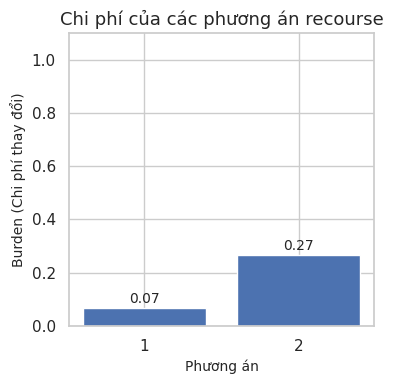

In [ ]:
plot_recourse_burden(top_k_cf)

In [ ]:
def print_recourse_changes(original, top_k_cf):
    for i, row in top_k_cf.iterrows():
        print(f"\n Recourse {i+1} (Burden: {row['burden_norm']:.2f}, Plausibility: {row.get('plausibility', 'Không rõ')}):")
        for col in original.index:
            if col in row and row[col] != original[col]:
                print(f"  - {col}: {original[col]} → {row[col]}")
print_recourse_changes(original, top_k_cf)


 Recourse 1 (Burden: 0.07, Plausibility: True):
  - Duration: 45 → 18

 Recourse 2 (Burden: 0.27, Plausibility: True):
  - Duration: 45 → 12


**Độ tin cậy: mức đồng thuận / cảnh báo khi mâu thuẫn**

In [ ]:
max_score = 4
agreementscore_df["Score (%)"] = agreementscore_df["Count"] / max_score

conflicts = agreementscore_df[agreementscore_df["Count"] == 1]["Feature"].tolist()

print("Mức độ đồng thuận giữa các phương pháp:")
display(agreementscore_df)

if conflicts:
    print("Cảnh báo: Một số đặc trưng chỉ được đề cập bởi 1 phương pháp giải thích → có thể gây mâu thuẫn:")
    for feat in conflicts:
        print(f"  - {feat}")
else:
    print("Không có mâu thuẫn đáng kể. Các đặc trưng được giải thích nhất quán giữa các phương pháp.")

Mức độ đồng thuận giữa các phương pháp:


Feature  Count                Methods  Score (%)
0      Checking account_unknown      3  DICE, LIME, Surrogate       0.75
1       Saving accounts_unknown      3  DICE, LIME, Surrogate       0.75
2                           Age      3       DICE, LIME, SHAP       0.75
3                 Credit amount      2             DICE, LIME       0.50
4          Saving accounts_rich      2             DICE, LIME       0.50
5             Purpose_education      2             DICE, LIME       0.50
6                   Housing_own      2             DICE, LIME       0.50
7         Checking account_rich      2             DICE, LIME       0.50
8              Purpose_radio/TV      2             DICE, LIME       0.50
9                      Sex_male      2             DICE, LIME       0.50
10                          Job      2             DICE, SHAP       0.50
11                     Duration      2        DICE, Surrogate       0.50
12                 Housing_rent      1                   DICE       0.25
13     Saving accounts_moderate      1                   DICE       0.25
14   Saving accounts_quite rich      1                   DICE       0.25
15    Checking account_moderate      1                   DICE       0.25
16                  Purpose_car      1                   DICE       0.25
17  Purpose_domestic appliances      1                   DICE       0.25
18  Purpose_furniture/equipment      1                   DICE       0.25
19              Purpose_repairs      1                   DICE       0.25
20      Purpose_vacation/others      1                   DICE       0.25

Cảnh báo: Một số đặc trưng chỉ được đề cập bởi 1 phương pháp giải thích → có thể gây mâu thuẫn:
  - Housing_rent
  - Saving accounts_moderate
  - Saving accounts_quite rich
  - Checking account_moderate
  - Purpose_car
  - Purpose_domestic appliances
  - Purpose_furniture/equipment
  - Purpose_repairs
  - Purpose_vacation/others


In [ ]:
import matplotlib.pyplot as plt

def plot_agreement_score(agreementscore_df):
    plt.figure(figsize=(8, 6))
    bars = plt.barh(agreementscore_df["Feature"], agreementscore_df["Score (%)"], color='green')

    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                 f"{width:.2f}", va='center', fontsize=9)

    plt.title("Mức đồng thuận giữa các phương pháp giải thích")
    plt.xlabel("Tỷ lệ xuất hiện")
    plt.xlim(0, 1.05)
    plt.tight_layout()
    plt.show()

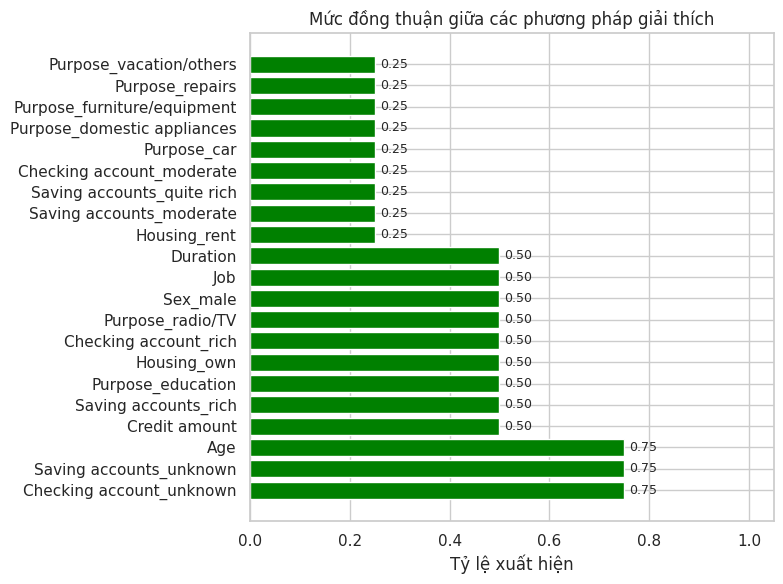

In [ ]:
plot_agreement_score(agreementscore_df)

In [ ]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 52.0 MB/s eta 0:00:00


In [ ]:
! pip install streamlit pyngrok --quiet

In [ ]:
!pip install pyngrok

In [ ]:
# 1) Cài thư viện
!pip install -q streamlit pyngrok

# 2) Chuẩn bị 3 folder & file tạm
import os, pandas as pd, textwrap
os.makedirs("tmp_data/lime", exist_ok=True)
os.makedirs("tmp_data/surrogate", exist_ok=True)
os.makedirs("tmp_data/recourse", exist_ok=True)

# LIME
lime_path = "tmp_data/lime/lime_explanation.pkl"
if not os.path.exists(lime_path):
    pd.DataFrame({
        "Feature": ["Age<=30", "Credit amount>2000", "Saving accounts=little"],
        "Weight": [0.25, -0.40, -0.15]
    }).to_pickle(lime_path)

# Surrogate
rule_path = "tmp_data/surrogate/surrogate_rule.txt"
if not os.path.exists(rule_path):
    rule_txt = textwrap.dedent('''\
if Credit amount > 1500:
    -> Reject
else:
    if Duration < 18:
        -> Approve
    else:
        -> Reject
''').strip()
    with open(rule_path, "w", encoding="utf-8") as f:
        f.write(rule_txt)

# Recourse
recourse_file = "tmp_data/recourse/recourse_examples.csv"
recourse_df = pd.DataFrame([
    {"Age": 40, "Credit amount": 1000, "Duration": 45, "Saving accounts": "little"},
    {"Age": 40, "Credit amount": 900, "Duration": 45, "Saving accounts": "moderate"}
])
recourse_df.to_csv(recourse_file, index=False)


print("✅ Đã chuẩn bị tmp_data/ với 3 file tạm.")

# 3) Ghi file app.py
with open("app.py", "w", encoding="utf-8") as f:
    f.write("""\
import streamlit as st
import pandas as pd
import os, random, textwrap

st.set_page_config(page_title="Giao diện recourse", page_icon="📄", layout="wide")
st.title("📄 Giao diện recourse cho người dùng cuối")
st.write("BUILD: 2025-08-14 – Demo")
st.subheader("📋 Nhập hồ sơ người dùng")

# --------- Khung nhập ----------
age = st.number_input("Tuổi", min_value=18, max_value=100, value=35)
sex = st.selectbox("Giới tính", ["male", "female"])
job = st.selectbox("Nghề nghiệp", [0, 1, 2, 3])
housing = st.selectbox("Loại nhà ở", ["own", "rent", "free"])
saving = st.selectbox("Tài khoản tiết kiệm", ["little", "moderate", "quite rich", "rich", "unknown"])
checking = st.selectbox("Tài khoản thanh toán", ["little", "moderate", "rich", "unknown"])
credit = st.number_input("Số tiền vay", min_value=0, value=1000)
duration = st.number_input("Thời hạn vay (tháng)", min_value=4, value=12)
purpose = st.selectbox(
    "Mục đích vay",
    ["radio/TV","education","furniture/equipment","new car","used car",
     "business","domestic appliances","repairs","vacation/others"]
)

if st.button("📨 Gửi hồ sơ"):
    # --------- Tạo hồ sơ ----------
    user_data = pd.DataFrame([{
        "Age": age, "Sex": sex, "Job": job, "Housing": housing,
        "Saving accounts": saving, "Checking account": checking,
        "Credit amount": credit, "Duration": duration, "Purpose": purpose
    }])

    st.success("Hồ sơ đã được ghi nhận.")
    st.subheader("📄 Thông tin hồ sơ")
    st.dataframe(user_data, use_container_width=True)

    # --------- Kết quả giả lập ----------
    result = random.choice(["Được chấp thuận", "Bị từ chối"])
    st.info(f"Kết quả dự đoán: {result}")

    # --------- LIME (import từ folder tạm) ----------
    lime_file = "tmp_data/lime/lime_explanation.pkl"
    if os.path.exists(lime_file):
        lime_df = pd.read_pickle(lime_file)
    else:
        lime_df = pd.DataFrame({
            "Feature": ["Age<=30", "Credit amount>2000", "Saving accounts=little"],
            "Weight": [0.25, -0.40, -0.15]
        })
        lime_df.to_pickle(lime_file)
    if not lime_df.empty:
        st.subheader("Giải thích LIME")
        st.dataframe(lime_df, use_container_width=True)

    # --------- Surrogate Rule (import từ folder tạm) ----------
    rule_file = "tmp_data/surrogate/surrogate_rule.txt"
    if os.path.exists(rule_file):
        with open(rule_file, "r", encoding="utf-8") as f2:
            rule = f2.read()
    else:
        rule = textwrap.dedent('''\
if Credit amount > 1500:
    -> Reject
else:
    if Duration < 18:
        -> Approve
    else:
        -> Reject
''').strip()
        with open(rule_file, "w", encoding="utf-8") as f2:
            f2.write(rule)

    st.subheader("Giải thích Surrogate Rule")
    st.code(rule)

    # --------- Recourse (import từ folder tạm) ----------
    recourse_file = "tmp_data/recourse/recourse_examples.csv"
    if os.path.exists(recourse_file):
        recourse_df = pd.read_csv(recourse_file)
    else:
        recourse_df = pd.DataFrame([
            {"Age": 40, "Credit amount": 1000, "Duration": 45, "Saving accounts": "little"},
            {"Age": 40, "Credit amount": 900, "Duration": 45, "Saving accounts": "moderate"}
        ])
        recourse_df.to_csv(recourse_file, index=False)

    if not recourse_df.empty:
        st.subheader("Recourse đề xuất")

        if "Burden" not in recourse_df.columns:
            recourse_df["Burden"] = 0.25
        if "Plausibility" not in recourse_df.columns:
            recourse_df["Plausibility"] = True

        # Hiển thị dạng text: so sánh với hồ sơ gốc
        for i, row in recourse_df.iterrows():
            burden = row.get("Burden", "?")
            plau   = row.get("Plausibility", "?")
            st.markdown(f"**Recourse {i+1} (Burden: {burden}, Plausibility: {plau})**:")
            for col in recourse_df.columns:
                if col in ["Burden", "Plausibility"]:
                    continue
                orig_val = user_data.iloc[0][col] if col in user_data.columns else None
                new_val  = row[col]
                if orig_val is not None and new_val != orig_val:
                    st.write(f"- {col}: {orig_val} → {new_val}")
            st.write("")

else:
    st.info("💡 Nhập thông tin và nhấn **Gửi hồ sơ** để xem LIME / Surrogate / Recourse.")
""")

# 4) Chạy Streamlit + ngrok
!pkill -f streamlit || true
!pkill -f ngrok || true

from pyngrok import ngrok
import subprocess, time
ngrok.set_auth_token("30qXeHf4pmJL7fPlIL4QxxMEh8B_7YHWTRUavGv6VJwsbePQZ")

process = subprocess.Popen(["streamlit", "run", "app.py", "--server.port", "8501"])
time.sleep(6)

public_url = ngrok.connect(8501)
print("🌐 Giao diện người dùng:", public_url)

✅ Đã chuẩn bị tmp_data/ với 3 file tạm.
^C
^C
🌐 Giao diện người dùng: NgrokTunnel: "https://283601f207ee.ngrok-free.app" -> "http://localhost:8501"
